In [ ]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
import cv2
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

In [ ]:
class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask, index

In [ ]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [ ]:
def iou(predicts, labels):
    res = []
    for output, label in zip(predicts, labels):
      tmp = torch.tensor([])

      out = output.softmax(0).argmax(0)
      lbl = label.argmax(0)
      for cls in range(len(VOC_CLASSES)):
        out_eq = out.eq(cls)
        label_eq = lbl.eq(cls)
        inter = torch.logical_and(out_eq, label_eq).sum()
        union = torch.logical_or(out_eq, label_eq).sum()

        result = -1.0
        if (union != 0):
          result = inter / union
        tmp = torch.cat((tmp, torch.tensor([result])))
      res.append(tmp)
    
    return torch.stack(res)

def miou(predicts, labels):
  result = iou(predicts, labels)
  return result[result >= 0].mean()

In [ ]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [ ]:
train_dataset = PascalVOCSearchDataset('.', transform = augs)
print(len(train_dataset))
valid_dataset = PascalVOCSearchDataset('.', image_set='val', transform = augs)
print(len(valid_dataset))

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .
1464
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
1449


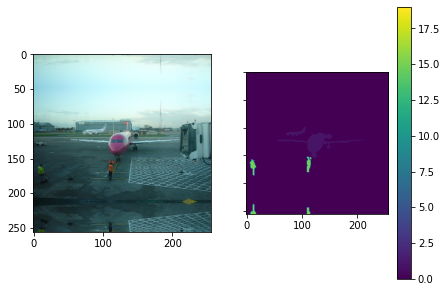

In [ ]:
img, lbl, idx = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [ ]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [ ]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-2)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = True, num_workers = 0)

In [ ]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [ ]:
model = model.cuda()

In [ ]:
run_number = 1

In [ ]:
r_losses = []
valid_losses = []
next_desc = "first epoch"


for epoch in range(5):
  rloss = 0
  model.train()
  for img, lbl, idx in tqdm(train_loader, desc = next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    rloss += loss.detach().cpu().item() / len(train_loader)

  valid_loss = 0
  miou_value = 0
  model.eval()
  with torch.no_grad():
    for img, lbl, idx in tqdm(valid_loader, desc='Validation'):
      img = img.cuda()
      lbl = lbl.cuda()
      predict = model(img)['out']
      loss = crit(predict, lbl)
      miou_value += miou(predict, lbl) / len(valid_loader)
      valid_loss += loss.detach().cpu().item() / len(valid_loader)

  valid_losses.append(valid_loss)
  r_losses+= [rloss]
  next_desc = f"Epoch: [{epoch+1}], previous rloss: [{rloss:.3f}], previous val loss: [{valid_loss:.3f}], previous miou value: [{miou_value:.3f}]"

with open('run_log.csv', 'a') as f:
  if run_number == 1:
    f.write('Run number,MIoU value\n')
  f.write(f'{run_number},{miou_value:.3f}\n')
  run_number += 1

Validation: 100%|██████████| 182/182 [04:33<00:00,  1.50s/it]
Epoch: [1], previous rloss: [0.836], previous val loss: [0.850], previous miou value: [0.345]: 100%|██████████| 183/183 [04:53<00:00,  1.61s/it]
Validation: 100%|██████████| 182/182 [04:36<00:00,  1.52s/it]
Epoch: [2], previous rloss: [0.703], previous val loss: [0.789], previous miou value: [0.343]: 100%|██████████| 183/183 [04:51<00:00,  1.59s/it]
Validation: 100%|██████████| 182/182 [04:32<00:00,  1.50s/it]
Epoch: [3], previous rloss: [0.632], previous val loss: [0.976], previous miou value: [0.335]: 100%|██████████| 183/183 [04:49<00:00,  1.58s/it]
Validation: 100%|██████████| 182/182 [04:28<00:00,  1.48s/it]
Epoch: [4], previous rloss: [0.577], previous val loss: [0.666], previous miou value: [0.409]: 100%|██████████| 183/183 [04:48<00:00,  1.58s/it]
Validation: 100%|██████████| 182/182 [04:16<00:00,  1.41s/it]


In [ ]:
print('Last epoch: ' + next_desc)

Last epoch: Epoch: [5], previous rloss: [0.614], previous val loss: [0.690], previous miou value: [0.391]


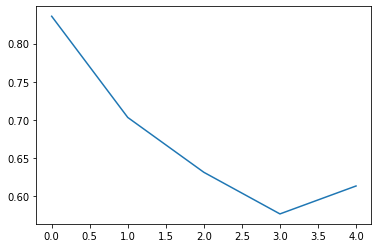

In [ ]:
plt.plot(r_losses)

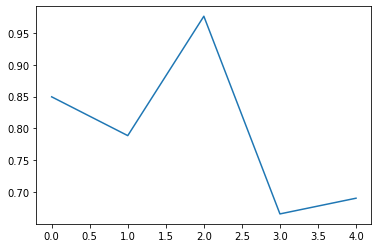

In [ ]:
plt.plot(valid_losses)

Picture #0
tensor(0.4721)
Picture #1
tensor(0.1697)
Picture #2
tensor(0.2326)
Picture #3
tensor(0.4650)
Picture #4
tensor(1.)
Picture #5
tensor(0.7818)
Picture #6
tensor(0.2255)
Picture #7
tensor(0.4533)


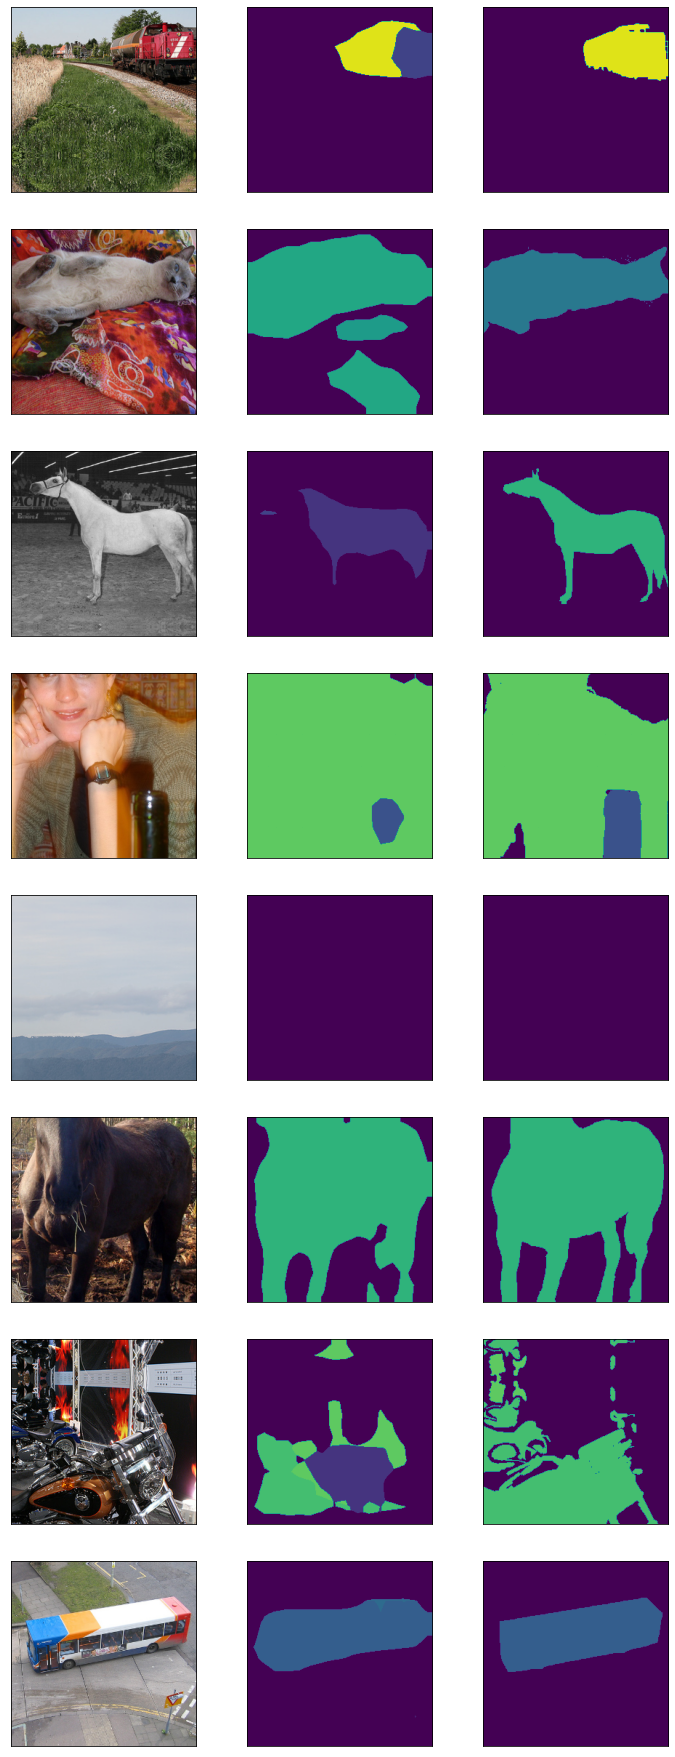

In [ ]:
 model.eval()
 with torch.no_grad():
   for img, lbl, idx in train_loader:
     img = img.cuda()
     lbl = lbl.cuda()
     predict = model(img)['out']
     break

count = 0
fig, axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu(), lbl.detach().cpu())):
  print(f'Picture #{count}')
  count += 1
  print(miou(spred.expand(1, *spred.shape), slbl.expand(1, *slbl.shape)))
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.softmax(0).argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

In [ ]:
def get_image(img, lbl, model):
  model.eval()
  with torch.no_grad():
    img = img.cuda()
    predict = model(img.expand(1, *img.shape))['out']

  simg = img.detach().cpu()
  spred = predict[0].detach().cpu()
  fig, ax = plt.subplots(1, 3, figsize=(12, len(lbl) * 4))
  ax[0].imshow(simg.permute(1,2,0))
  ax[1].imshow(spred.softmax(0).argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  ax[2].imshow(lbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  [ax.get_xaxis().set_visible(False) for ax in  fig.axes]
  [ax.get_yaxis().set_visible(False) for ax in fig.axes]
  fig.show()

In [ ]:
ious = []
mious = []
indices = []

model.eval()
with torch.no_grad():
  for img, lbl, idx  in tqdm(valid_loader, desc='Collecting IoU'):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    ious += iou(predict, lbl)
    indices += idx

  for i in range(len(ious)):
    mious.append(ious[i][ious[i] >= 0].mean())

sorted_by_idx = np.argsort(mious)

## Картинки, попадающие в первые 10%

Picture #1, MIoU value: 0.8964807987213135
Picture #2, MIoU value: 0.9133890271186829


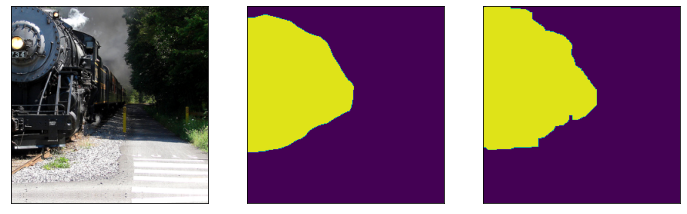

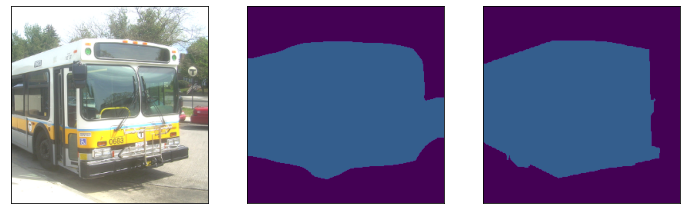

In [ ]:
print(f'Picture #1, MIoU value: {mious[sorted_by_idx[int(len(sorted_by_idx) * 0.96)]]}')
img, lbl, _ = valid_dataset[indices[sorted_by_idx[int(len(sorted_by_idx) * 0.96)]]]
get_image(img, lbl, model)
print(f'Picture #2, MIoU value: {mious[sorted_by_idx[int(len(sorted_by_idx) * 0.97)]]}')
img, lbl, _ = valid_dataset[indices[sorted_by_idx[int(len(sorted_by_idx) * 0.97)]]]
get_image(img, lbl, model)

## Картинки, попадающие в первые 15% - 25%

Picture #1, MIoU value: 0.6314976811408997
Picture #2, MIoU value: 0.6504942774772644


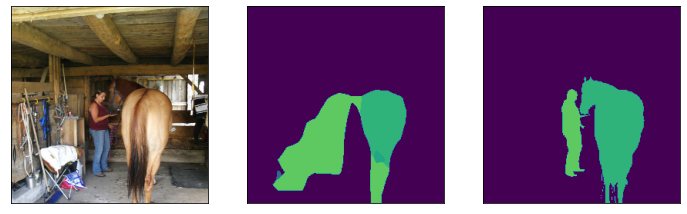

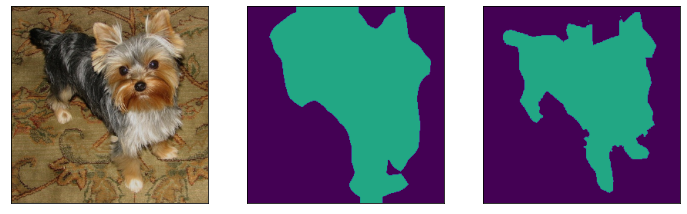

In [ ]:
print(f'Picture #1, MIoU value: {mious[sorted_by_idx[int(len(sorted_by_idx) * 0.77)]]}')
img, lbl, _ = valid_dataset[indices[sorted_by_idx[int(len(sorted_by_idx) * 0.77)]]]
get_image(img, lbl, model)
print(f'Picture #2, MIoU value: {mious[sorted_by_idx[int(len(sorted_by_idx) * 0.78)]]}')
img, lbl, _ = valid_dataset[indices[sorted_by_idx[int(len(sorted_by_idx) * 0.78)]]]
get_image(img, lbl, model)

## Картинки, попадающие в первые 45% - 55%

Picture #1, MIoU value: 0.3545427620410919
Picture #2, MIoU value: 0.36080047488212585


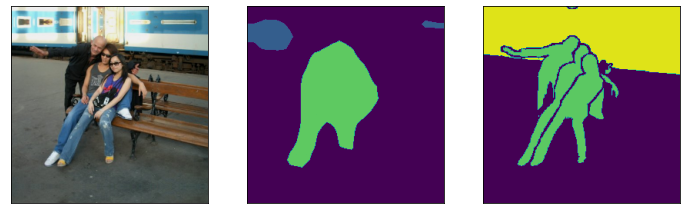

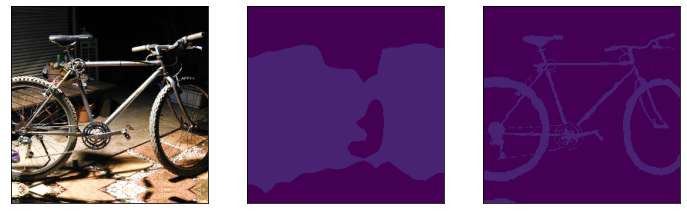

In [ ]:
print(f'Picture #1, MIoU value: {mious[sorted_by_idx[int(len(sorted_by_idx) * 0.47)]]}')
img, lbl, _ = valid_dataset[indices[sorted_by_idx[int(len(sorted_by_idx) * 0.47)]]]
get_image(img, lbl, model)
print(f'Picture #2, MIoU value: {mious[sorted_by_idx[int(len(sorted_by_idx) * 0.48)]]}')
img, lbl, _ = valid_dataset[indices[sorted_by_idx[int(len(sorted_by_idx) * 0.48)]]]
get_image(img, lbl, model)

In [ ]:
cls_to_iou = dict()
for i in range(len(ious)):
  assert len(ious[i]) == len(VOC_CLASSES)
  for cls in range(len(ious[i])):
    if ious[i][cls] != -1:
      if cls not in cls_to_iou:
        cls_to_iou[cls] = []
      cls_to_iou[cls].append((ious[i][cls], indices[i]))

Picture with the best IoU value = 0.919979453086853 for class aeroplane


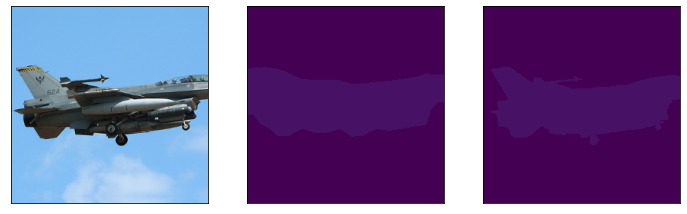

In [ ]:
cls_1 = 1
pic = max(cls_to_iou[cls_1], key=lambda p: p[0])
img, lbl, _ = valid_dataset[pic[1]]
print(f'Picture with the best IoU value = {pic[0]} for class ' + VOC_CLASSES[cls_1])
get_image(img, lbl, model)

Picture with the best IoU value = 0.9935821294784546 for class bus


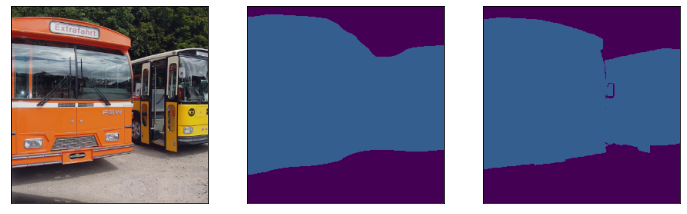

In [ ]:
cls_2 = 6
pic = max(cls_to_iou[cls_2], key=lambda p: p[0])
img, lbl, _ = valid_dataset[pic[1]]
print(f'Picture with the best IoU value = {pic[0]} for class ' + VOC_CLASSES[cls_2])
get_image(img, lbl, model)

Picture with the best IoU value = 0.9558005332946777 for class train


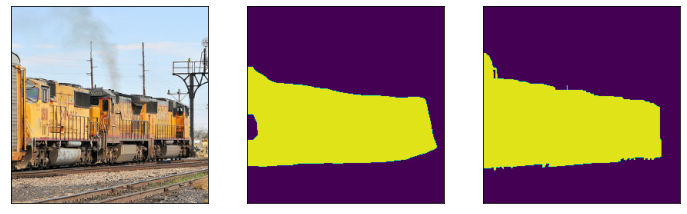

In [ ]:
cls_3 = 19
pic = max(cls_to_iou[cls_3], key=lambda p: p[0])
img, lbl, _ = valid_dataset[pic[1]]
print(f'Picture with the best IoU value = {pic[0]} for class ' + VOC_CLASSES[cls_3])
get_image(img, lbl, model)

In [ ]:
for i in range(len(VOC_CLASSES)):
  print('MIoU for class ' + VOC_CLASSES[i] + ' = ' + str(np.mean([p[0] for p in cls_to_iou[i]])))

MIoU for class background = 0.7502223
MIoU for class aeroplane = 0.27347043
MIoU for class bicycle = 0.09112226
MIoU for class bird = 0.18194708
MIoU for class boat = 0.11270032
MIoU for class bottle = 0.10034634
MIoU for class bus = 0.30470294
MIoU for class car = 0.18766347
MIoU for class cat = 0.24162947
MIoU for class chair = 0.00064796594
MIoU for class cow = 0.17097253
MIoU for class diningtable = 0.14661762
MIoU for class dog = 0.18131088
MIoU for class horse = 0.20388116
MIoU for class motorbike = 0.25740415
MIoU for class person = 0.33046415
MIoU for class potted plant = 0.072962336
MIoU for class sheep = 0.16589539
MIoU for class sofa = 0.076961584
MIoU for class train = 0.35591224
MIoU for class tv/monitor = 0.19415374
